In [1]:
# setup our notebook environment

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import gmaps
import gmaps.datasets
from pandas_profiling import ProfileReport

from scipy.stats import norm, ttest_ind, pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

from env import host, user, password
import acquire
import split_scale

## Deliverables

What should the zillow team expect to receive from you? Again, as you were communicating to them, not to your instructors.

A report (in the form of a presentation, both verbal and through a slides)

1. The report/presentation slides should summarize your findings about the drivers of the single unit property values. This will come from the analysis you do during the exploration phase of the pipeline. In the report, you should have visualizations that support your main points.

    The presentation should be no longer than 5 minutes, and consist of 3-5 slides.<br><br>
   

2. A github repository containing your work.

    This repository should consist of at least 1 jupyter notebook that walks through the pipeline, but you may wish to split your work among 2 notebooks, one for exploration, and one for modeling.

    Make sure your notebooks answer all the questions posed in the email from the Zillow data science team.

    The repository should also contain the .py files necessary to reproduce your work, and your work must be reproducible by someone with their own env.py file.

### Other Notes

- For the first iteration of your model, use only square feet of the home, number of bedrooms, and number of bathrooms to estimate the properties assessed value, 'taxvaluedollarcnt'. You can expand this to other fields after you have completed an mvp (minimally viable product).
- You will want to read and re-read the requirements given by your stakeholders to be sure you are meeting all of their needs and representing it in your data, report and model.
- You will want to do some data validation or QA (quality assurance) to be sure the data you gather is what you think it is.
- You will want to make sure you are using the best fields to represent square feet of home, number of bedrooms and number of bathrooms. "Best" meaning the most accurate and available information. Here you will need to do some data investigation in the database and use your domain expertise to make some judgement calls.

***For use throughout:***

## Data dictionary

*Target Variable:*

- **home_value** - formerly taxvaluedollarcnt, this was the data used to predict what someone would possible pay for a property

*Independent Variable:*

- **bathrooms** - formerly bathroomcnt, this is a count of total number of bathrooms a property has
- **bedrooms** - formerly bedroomcnt, this is a count of the total number of bedrooms a property has
- **sqft** - formerly calculatedfinishedsquarefeet, this was used in leiu of other squarefeet columns due to the high null count, and lack of clarity for where those calculations were coming from
- **zip** - formerly regionidzip, the zip code of the property
- **taxes** - formerly taxamount, the annual taxes accessed on the property
- **SFR** - formerly propertylandusetypeid, there were numerous property types in the data, commercial, lot, etc. The deliverables to the team were to contain *single unit property values*, so we went with the single family residential type.
- **fips** - county assigned fips numbers - 6037: Los Angeles County 6059: Orange County 6111: Venture County
- **latitude** - property latitude
- **longitude** - property longitude

*Data Scaling*

- **Robust Scaler** - Due to the nature of the data we went with the IQR Robust scaler. Outliers with the data, the varied use of numbers, as meaurements(sqft), cost(home_value), quantity(beds/baths), made the use of this particular scaler make sense.

In [2]:
# function to query db and return df

zillow = acquire.wrangle_zillow()

In [3]:
zillow.head()

,bathrooms,bedrooms,sqft,zip,home_value,taxes,SFR,fips,latitude,longitude
0,2.0,3.0,1900.0,96414.0,102890.0,1366.18,261.0,6037.0,34203666.0,-118454021.0
1,5.0,4.0,4611.0,96337.0,2589352.0,32250.78,261.0,6037.0,34137969.0,-118678815.0
2,2.0,4.0,1902.0,96469.0,607000.0,7295.24,261.0,6037.0,34112028.0,-117747321.0
3,1.0,2.0,764.0,96229.0,38473.0,915.17,261.0,6037.0,33834888.0,-118281058.0
4,2.0,4.0,2554.0,96339.0,355165.0,4553.51,261.0,6037.0,34210434.0,-118644312.0


In [4]:
zillow.describe()

,bathrooms,bedrooms,sqft,zip,home_value,taxes,SFR,fips,latitude,longitude
count,14990.000000,14990.000000,14990.000000,14982.000000,1.499000e+04,14989.000000,14990.0,14990.000000,1.499000e+04,1.499000e+04
mean,2.329153,3.316878,1943.132355,96651.749499,5.416945e+05,6597.894501,261.0,6049.381721,3.402249e+07,-1.181957e+08
std,1.019375,0.936250,1001.275394,4970.071943,7.309388e+05,8453.776520,0.0,21.225607,2.760549e+05,3.593028e+05
min,1.000000,1.000000,300.000000,95982.000000,1.050400e+04,51.260000,261.0,6037.000000,3.334085e+07,-1.193883e+08
25%,2.000000,3.000000,1276.000000,96208.000000,1.990028e+05,2710.810000,261.0,6037.000000,3.382366e+07,-1.184062e+08
50%,2.000000,3.000000,1680.000000,96414.000000,3.851740e+05,4776.080000,261.0,6037.000000,3.402708e+07,-1.181547e+08
75%,3.000000,4.000000,2346.000000,96996.000000,6.449650e+05,7678.440000,261.0,6059.000000,3.419064e+07,-1.179260e+08
max,11.000000,12.000000,15450.000000,399675.000000,2.385837e+07,276797.830000,261.0,6111.000000,3.477966e+07,-1.175554e+08


In [5]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14990 entries, 0 to 14989
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bathrooms   14990 non-null  float64
 1   bedrooms    14990 non-null  float64
 2   sqft        14990 non-null  float64
 3   zip         14982 non-null  float64
 4   home_value  14990 non-null  float64
 5   taxes       14989 non-null  float64
 6   SFR         14990 non-null  float64
 7   fips        14990 non-null  float64
 8   latitude    14990 non-null  float64
 9   longitude   14990 non-null  float64
dtypes: float64(10)
memory usage: 1.1 MB


In [6]:
zillow.isna().sum()

bathrooms     0
bedrooms      0
sqft          0
zip           8
home_value    0
taxes         1
SFR           0
fips          0
latitude      0
longitude     0
dtype: int64

In [7]:
# clean the data

zillow = acquire.clean_zillow_data(zillow)

In [8]:
zillow.head()

,bathrooms,bedrooms,sqft,zip,home_value,taxes,SFR,fips,latitude,longitude
0,2,3,1900,96414,102890,1366.18,261,6037,34.203666,-118.454021
1,5,4,4611,96337,2589352,32250.78,261,6037,34.137969,-118.678815
2,2,4,1902,96469,607000,7295.24,261,6037,34.112028,-117.747321
3,1,2,764,96229,38473,915.17,261,6037,33.834888,-118.281058
4,2,4,2554,96339,355165,4553.51,261,6037,34.210434,-118.644312


In [9]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14981 entries, 0 to 14989
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bathrooms   14981 non-null  int64  
 1   bedrooms    14981 non-null  int64  
 2   sqft        14981 non-null  int64  
 3   zip         14981 non-null  int64  
 4   home_value  14981 non-null  int64  
 5   taxes       14981 non-null  float64
 6   SFR         14981 non-null  int64  
 7   fips        14981 non-null  int64  
 8   latitude    14981 non-null  float64
 9   longitude   14981 non-null  float64
dtypes: float64(3), int64(7)
memory usage: 1.3 MB


In [10]:
# run a pandas-profile on the df

profile = ProfileReport(zillow, title='Pandas Profiling Report', html={'style':{'full_width':True}})

KeyboardInterrupt: 

In [ ]:
profile

# getting some interesting findings here. not unexpected but interesting. taxes and home_value are correlated
# zip is highly skewed
# bedroom and bathroom interaction
# etc.

In [11]:
# now to calculate the tax rate

zillow['tax_rate'] = zillow['taxes'] / zillow['home_value']

In [12]:
zillow.head()

,bathrooms,bedrooms,sqft,zip,home_value,taxes,SFR,fips,latitude,longitude,tax_rate
0,2,3,1900,96414,102890,1366.18,261,6037,34.203666,-118.454021,0.013278
1,5,4,4611,96337,2589352,32250.78,261,6037,34.137969,-118.678815,0.012455
2,2,4,1902,96469,607000,7295.24,261,6037,34.112028,-117.747321,0.012019
3,1,2,764,96229,38473,915.17,261,6037,33.834888,-118.281058,0.023787
4,2,4,2554,96339,355165,4553.51,261,6037,34.210434,-118.644312,0.012821


In [13]:
# now to add the county for the FIPS numbers provided from the db
# using this resource here
# https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=2&ved=2ahUKEwi27cfmn9noAhVNnKwKHSFhBNgQFjABegQIBRAB&url=https%3A%2F%2Fwww2.census.gov%2Fprograms-surveys%2Fpopest%2Fgeographies%2F2017%2Fall-geocodes-v2017.xlsx&usg=AOvVaw1o_RYNM9evsn9LJdV2iXC1
# it will download an excel file of the 2017 fips codes, as they can change annually

zillow['county_name'] = zillow['fips'].map({6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'})

In [14]:
# checking to see a spread across the data for county_name visiiblity
zillow.sample(20)

,bathrooms,bedrooms,sqft,zip,home_value,taxes,SFR,fips,latitude,longitude,tax_rate,county_name
3082,2,4,1553,97318,165683,2932.33,261,6037,34.668709,-118.074101,0.017698,Los Angeles
3194,4,5,2968,96395,783227,11738.03,261,6037,34.390870,-118.598421,0.014987,Los Angeles
1504,2,3,1374,96494,93771,1298.31,261,6037,34.114339,-117.773887,0.013846,Los Angeles
1373,2,3,1102,96474,432541,5305.95,261,6037,34.094840,-117.888606,0.012267,Los Angeles
12784,2,3,1929,96987,662742,6654.36,261,6059,33.552169,-117.703928,0.010041,Orange
12043,2,3,1557,96987,83003,787.80,261,6059,33.533620,-117.698593,0.009491,Orange
13589,1,1,623,97048,116672,1860.14,261,6059,33.776034,-117.973533,0.015943,Orange
11067,2,4,1933,96974,645557,6483.38,261,6059,33.575517,-117.730726,0.010043,Orange
4446,3,3,3283,96027,1417529,17109.29,261,6037,34.102657,-118.358923,0.012070,Los Angeles
9057,1,2,884,96284,241368,2990.28,261,6037,34.260500,-118.300128,0.012389,Los Angeles


In [15]:
# add to.csv if time allows

In [16]:
# Create Distributions of the Tax Rates by County:

# Using the above resource we found a breakdown of fips numbers form 2017
# with this information we know all the counties are in California

# Below is a breakdown of the county representation in our data, and the corresponding tax rates and distribution.

county_distribution = pd.DataFrame(zillow.groupby('county_name').county_name.count())
county_distribution.columns = ['count']

In [17]:
county_distribution

,count
county_name,
Los Angeles,9601
Orange,4093
Ventura,1287


In [18]:
county_distribution['frequency'] = zillow['county_name'].value_counts(normalize=True)

In [19]:
county_distribution

,count,frequency
county_name,,
Los Angeles,9601,0.640878
Orange,4093,0.273213
Ventura,1287,0.085909


In [20]:
county_distribution['percentage'] = round(county_distribution['frequency'] * 100)

In [21]:
county_distribution

,count,frequency,percentage
county_name,,,
Los Angeles,9601,0.640878,64.0
Orange,4093,0.273213,27.0
Ventura,1287,0.085909,9.0


In [22]:
# looked at the count of properties in each county, and my df is made up of 64% Los Angeles County 
# properties, 27% Orange County, and 9% Ventura County.

In [23]:
county_median_tax_rate = pd.DataFrame(round(zillow.groupby('county_name').tax_rate.median(), 3) * 100)
county_median_tax_rate.columns = ['tax_rate']

In [24]:
county_median_tax_rate

,tax_rate
county_name,
Los Angeles,1.3
Orange,1.2
Ventura,1.1


### regarding tax rates, it seems that LA county has the high tax rate, but there isn't too much of a difference between the rates

In [25]:
# lets visualize this data
los_angeles_tax_dist = zillow[zillow.county_name == "Los Angeles"].tax_rate
orange_tax_dist = zillow[zillow.county_name == "Orange"].tax_rate
ventura_tax_dist = zillow[zillow.county_name == "Ventura"].tax_rate

Text(0.5, 1.0, '2017 Tax Distribution for Los Angeles County')

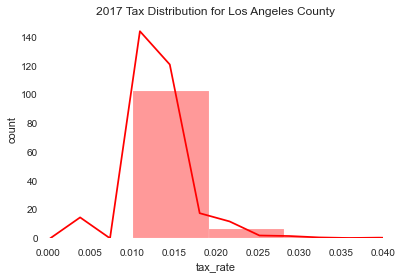

In [26]:
sns.distplot(los_angeles_tax_dist, color = 'Red')
plt.xlim(0, 0.04)
plt.ylabel('count')
plt.title('2017 Tax Distribution for Los Angeles County')

Text(0.5, 1.0, '2017 Tax Distribution for Orange County')

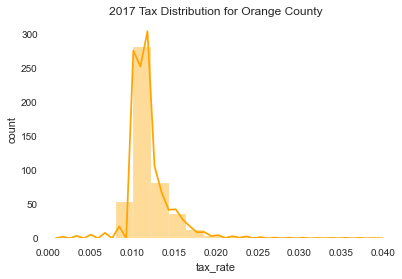

In [27]:
sns.distplot(orange_tax_dist, color = 'Orange')
plt.xlim(0, 0.04)
plt.ylabel('count')
plt.title('2017 Tax Distribution for Orange County')

Text(0.5, 1.0, '2017 Tax Distribution for Orange County')

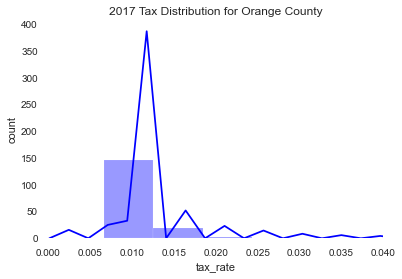

In [28]:
sns.distplot(ventura_tax_dist, color = 'Blue')
plt.xlim(0, 0.04)
plt.ylabel('count')
plt.title('2017 Tax Distribution for Orange County')

In [34]:
# spliting the data into train, test
# 80/20 train to test
# setting seed at 19 for reproducibilty

train, test = split_scale.split_my_data(zillow, .8, 19)

In [35]:
train.head()

,bathrooms,bedrooms,sqft,zip,home_value,taxes,SFR,fips,latitude,longitude,tax_rate,county_name
2473,2,2,1028,95987,49256,650.57,261,6037,34.054722,-118.293726,0.013208,Los Angeles
881,1,3,1779,96193,446000,5658.06,261,6037,33.897191,-118.073931,0.012686,Los Angeles
9554,2,3,1380,96451,322756,4054.12,261,6037,34.193206,-118.419501,0.012561,Los Angeles
8611,1,3,1850,95992,361000,4500.39,261,6037,34.016274,-118.251801,0.012466,Los Angeles
4082,2,3,1330,96522,72642,1178.41,261,6037,33.996883,-117.858115,0.016222,Los Angeles


In [36]:
train.shape

(11984, 12)

In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11984 entries, 2473 to 13923
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bathrooms    11984 non-null  int64  
 1   bedrooms     11984 non-null  int64  
 2   sqft         11984 non-null  int64  
 3   zip          11984 non-null  int64  
 4   home_value   11984 non-null  int64  
 5   taxes        11984 non-null  float64
 6   SFR          11984 non-null  int64  
 7   fips         11984 non-null  int64  
 8   latitude     11984 non-null  float64
 9   longitude    11984 non-null  float64
 10  tax_rate     11984 non-null  float64
 11  county_name  11984 non-null  object 
dtypes: float64(4), int64(7), object(1)
memory usage: 1.2+ MB


In [39]:
# split our data into X and y train/test

X_train = train[['sqft', 'bedrooms', 'bathrooms']]
X_test = test[['sqft', 'bedrooms', 'bathrooms']]
y_train = train[['home_value']]
y_test = test[['home_value']]

In [40]:
X_train.head()

,sqft,bedrooms,bathrooms
2473,1028,2,2
881,1779,3,1
9554,1380,3,2
8611,1850,3,1
4082,1330,3,2


In [41]:
y_train.head()

,home_value
2473,49256
881,446000
9554,322756
8611,361000
4082,72642


# Data exploration

## Goal: Address each of the questions you posed in your planning and brainstorming and any others you have come up with along the way through visual or statistical analysis.

### Which independent variables do you think influence the value of a home?

The general hypothesis is that the variables that influence the value of home are square feet, bedrooms, and bathrooms.

More square footage, or room count, the higher the potential value.

This seems to be a overly simplistic, as home ammenties, location, schools in the area, etc. will have additional influence, and potentially more.

However, for the team deliverables we will look at these three variables.

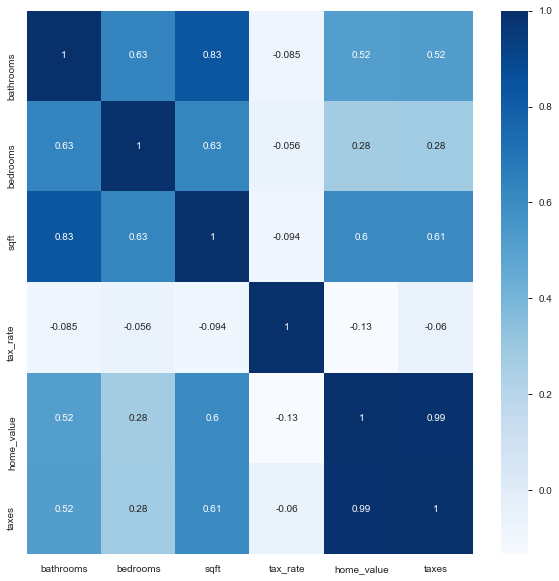

In [57]:
plt.figure(figsize=(10,10))
cor = train[['bathrooms','bedrooms','sqft','tax_rate', 'home_value', 'taxes']].corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Blues)
plt.show()

1      177
2     2349
3     6662
4     4420
5     1155
6      183
7       27
8        1
9        2
10       1
11       1
12       3
Name: bedrooms, dtype: int64


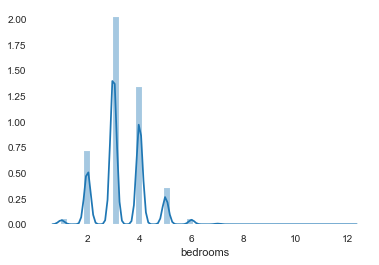

In [59]:
sns.distplot(zillow.bedrooms)

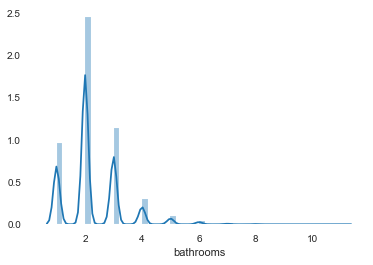

In [61]:
sns.distplot(zillow.bathrooms)

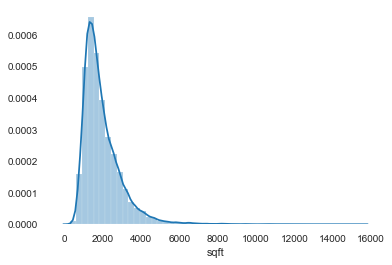

In [62]:
sns.distplot(zillow.sqft)

(0.0, 7.0)

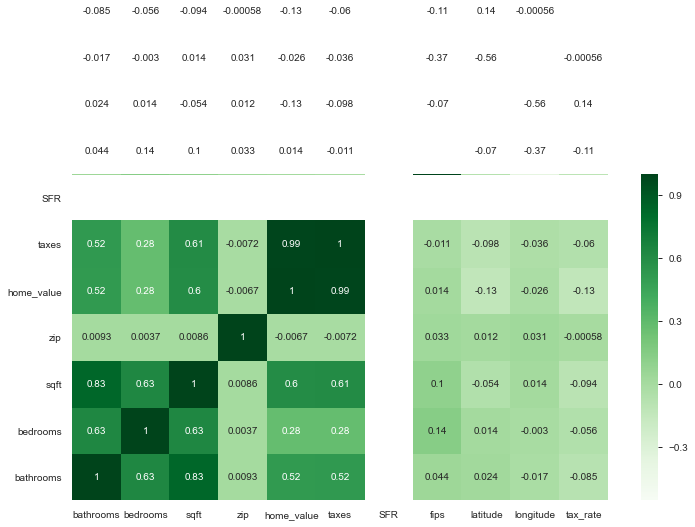

In [53]:
plt.figure(figsize=(12,6))
sns.heatmap(train.corr(), cmap='Greens', annot=True)
plt.ylim(0, 7)

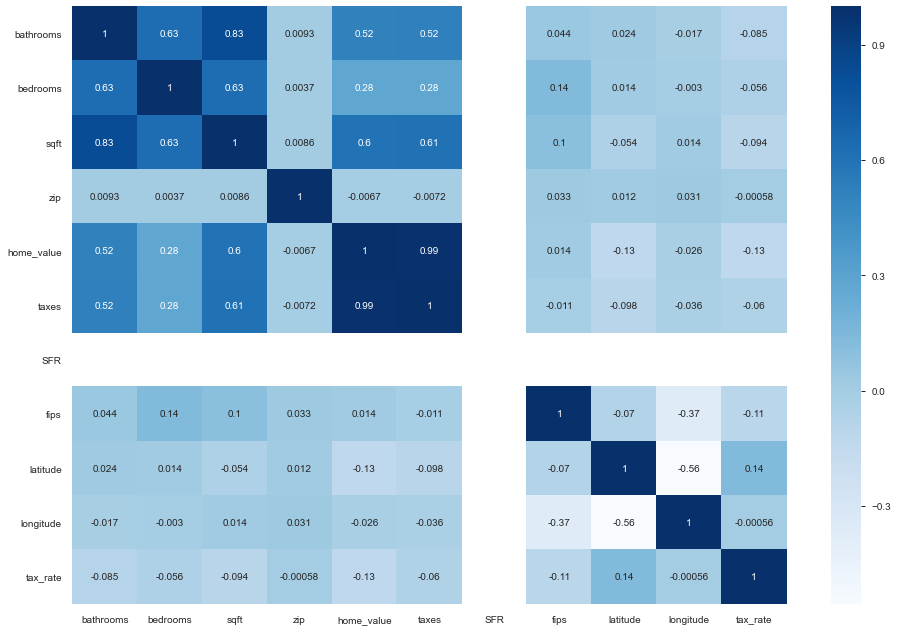

In [71]:
plt.figure(figsize = (16,11))
sns.heatmap(train.corr(), cmap = 'Blues', annot = True )

Run at least 1 t-test and 1 correlation test (but as many as you need!)

### Is there a difference in home value between 1 or 3 bedrooms?

> $H_0$: There is no difference in home value between having 1 bedroom vs 3 bedrooms

> $H_a$: There is a difference in home value between having 1 bedroom vs 3 bedrooms

In [76]:
alpha = .05

x1 = train[train.bedrooms == 1].home_value
x2 = train[train.bedrooms == 3].home_value

r, p = ttest_ind(x1, x2)
r, p

(-2.126241778994122, 0.03352839302443865)

In [78]:
print(f'''
Because p ({p:.4f}) > alpha (.05), we reject the null hypothesis that 
there is a difference in home value between having 1 bedroom vs 3 bedrooms.
''')


Because p (0.0335) > alpha (.05), we reject the null hypothesis that 
there is a difference in home value between having 1 bedroom vs 3 bedrooms.



### Does sqft correlate with home vale?

> $H_0$: There is no linear relationship between sqft and home value

> $H_a$: There is a linear relationship between sqft and home value

In [84]:
x = train.sqft
y = train.home_value

r, p = pearsonr(x, y)

print('r =', r)
print('p =', p)

r = 0.6041151990805946
p = 0.0


In [86]:
print(f'''
Because p ({p:.1f}) > alpha (.05), we reject the null hypothesis that there is no linear relationship
between sqft and home value.
''')


Because p (0.0) > alpha (.05), we reject the null hypothesis that there is no linear relationship
between sqft and home value.



In [79]:
# Fun visual using lat and long

fig = gmaps.Map(layout={'width': '1000px', 'height': '400px', 'padding': '10px'})
fig.add_layer(gmaps.heatmap_layer(zillow[['latitude', 'longitude']], weights=zillow['home_value']))
fig

Map(configuration={'api_key': None}, data_bounds=[(33.470286350631035, -118.91369264051497), (34.5745974552562…

# Modeling

## Goal: develop a regression model that performs better than a baseline.

In [87]:
# first I want to create dataframe to contain our actual values and model performance

predictions_train=pd.DataFrame({'actual':y_train.home_value})

In [88]:
predictions_train.head()

,actual
2473,49256
881,446000
9554,322756
8611,361000
4082,72642


In [93]:
# we will create a baseline, so we have something to measure model performance against

baseline_train = np.array([y_train.mean()[0]]*len(y_train))
predictions_train['baseline'] = baseline_train

In [94]:
predictions_train.head()

,actual,baseline
2473,49256,539994.634179
881,446000,539994.634179
9554,322756,539994.634179
8611,361000,539994.634179
4082,72642,539994.634179


In [95]:
lm = LinearRegression()

lm.fit(X_train,y_train)

lm_predictions=lm.predict(X_train)

predictions_train['lm']= lm_predictions

In [96]:
predictions_train.head()

,actual,baseline,lm
2473,49256,539994.634179,296718.848648
881,446000,539994.634179,414698.008468
9554,322756,539994.634179,309678.683321
8611,361000,539994.634179,447129.657347
4082,72642,539994.634179,286839.493970


In [99]:
predictions_train['residuals'] = predictions_train.lm - predictions_train.actual

In [100]:
predictions_train.head()

,actual,baseline,lm,residuals
2473,49256,539994.634179,296718.848648,247462.848648
881,446000,539994.634179,414698.008468,-31301.991532
9554,322756,539994.634179,309678.683321,-13077.316679
8611,361000,539994.634179,447129.657347,86129.657347
4082,72642,539994.634179,286839.493970,214197.493970


<function matplotlib.pyplot.show(*args, **kw)>

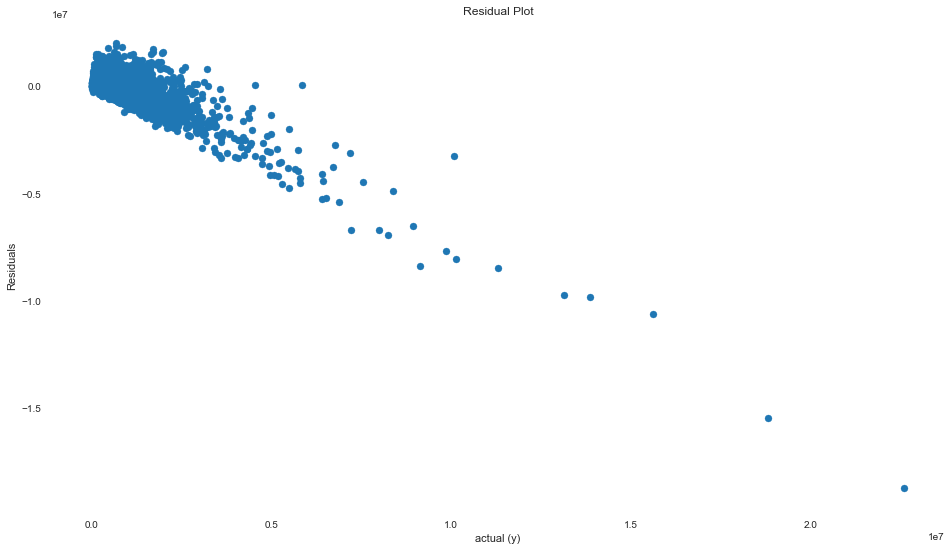

In [108]:
plt.figure(figsize=(16,9))

plt.scatter(x = predictions_train.actual, y = predictions_train.residuals)
plt.title('Residual Plot')
plt.xlabel('actual (y)')
plt.ylabel('Residuals')

plt.show

### Well, there is definitely something here. Let's some evaluatation to put some numbers to what we're seeing.

## Evaluate our model to get the RMSE and $R^2$ values

In [110]:
predictions_train.head()

,actual,baseline,lm,residuals
2473,49256,539994.634179,296718.848648,247462.848648
881,446000,539994.634179,414698.008468,-31301.991532
9554,322756,539994.634179,309678.683321,-13077.316679
8611,361000,539994.634179,447129.657347,86129.657347
4082,72642,539994.634179,286839.493970,214197.493970


In [113]:
def regression_errors(df):
    """
    Return a DataFrame with the SSE, ESS, TSS, MSE, RMSE for the y variable
    
    """
    #SSE
    SSE = mean_squared_error(df.actual, df.lm) * len(df)
    #ESS
    ESS = sum((df.lm - df['actual'].mean())**2)
    #TSS
    TSS = SSE + ESS
    #MSE
    MSE = mean_squared_error(df.actual, df.lm)
    #RMSE
    RMSE = sqrt(mean_squared_error(df.actual, df.lm))
    
    return SSE, ESS, TSS, MSE, RMSE

In [115]:
SSE, ESS, TSS, MSE, RMSE = regression_errors(predictions_train)

In [116]:
print(f'SSE: {round(SSE, 3)}')
print(f'ESS: {round(ESS, 3)}')
print(f'TSS: {round(TSS, 3)}')
print(f'MSE: {round(MSE, 3)}')
print(f'RMSE: {round(RMSE,3)}')

SSE: 3738859167955487.5
ESS: 2355210129610850.0
TSS: 6094069297566338.0
MSE: 311987580770.652
RMSE: 558558.485


In [117]:
r2 = r2_score(predictions_train.actual, predictions_train.lm)

In [118]:
r2

0.3864757708862221